<a href="https://colab.research.google.com/github/NickSlm/ml1/blob/main/chp17_e10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [8]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()

In [9]:
X_train, y_train = X_train_full[5000:], y_train_full[5000:]
X_val, y_val = X_train_full[:5000], y_train_full[:5000]

X_train = X_train / 255.
X_val = X_val / 255.
X_test = X_test / 255.

In [10]:
def rounded_accuracy(y_true, y_pred):
  return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [11]:
class Sampling(keras.layers.Layer):
  def call(self, inputs):
    z_mean, z_sigma = inputs
    epsilon = keras.backend.random_normal(tf.shape(z_sigma))
    return z_mean + tf.math.exp(z_sigma / 2) * epsilon

In [12]:
INPUT_SHAPE = [32,32,3]
CODING_DIMS = 100

inputs = keras.layers.Input(shape=INPUT_SHAPE)
z = keras.layers.Conv2D(filters=16, kernel_size=3, padding="same", activation="selu")(inputs)
z = keras.layers.BatchNormalization()(z)
z = keras.layers.MaxPool2D(pool_size=2)(z)
z = keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="selu")(z)
z = keras.layers.BatchNormalization()(z)
z = keras.layers.MaxPool2D(pool_size=2)(z)
z = keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="selu")(z)
z = keras.layers.BatchNormalization()(z)
z = keras.layers.MaxPool2D(pool_size=2)(z)
z = keras.layers.Flatten()(z)
z = keras.layers.Dense(512, activation="selu")(z)
z = keras.layers.BatchNormalization()(z)
z = keras.layers.Dense(256, activation="selu")(z)
z = keras.layers.BatchNormalization()(z)
z = keras.layers.Dense(128, activation="selu")(z)
z = keras.layers.BatchNormalization()(z)
z = keras.layers.Dense(CODING_DIMS, activation="selu")(z)
codings_mean = keras.layers.Dense(CODING_DIMS)(z)
codings_log_var = keras.layers.Dense(CODING_DIMS)(z)
codings = Sampling()([codings_mean, codings_log_var])

var_encoder = keras.models.Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

In [13]:
decoder_inputs = keras.layers.Input(shape=[CODING_DIMS])
x = keras.layers.Dense(128, activation="selu")(decoder_inputs)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(256, activation="selu")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(512, activation="selu")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(4*4*64, activation="selu")(x)
x = keras.layers.Reshape([4,4,64])(x)
x = keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding="same", activation="selu")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding="same", activation="selu")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding="same", activation="selu")(x)
x = keras.layers.BatchNormalization()(x)
output = keras.layers.Conv2DTranspose(filters=3, kernel_size=3, padding="same", activation="sigmoid")(x)

var_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[output])

In [14]:
_, _, codings = var_encoder(inputs)
reconstructions = var_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

In [15]:
kl_divergence = -0.5 * keras.backend.sum(1 + codings_log_var - keras.backend.exp(codings_log_var) - keras.backend.square(codings_mean), axis=-1)

variational_ae.add_loss(keras.backend.mean(kl_divergence) / 3072.)
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=32,
                             validation_data=(X_val, X_val))

Epoch 1/25
1407/1407 [==============================] - 44s 23ms/step - loss: 0.6299 - rounded_accuracy: 0.7823 - val_loss: 0.6345 - val_rounded_accuracy: 0.7931
Epoch 2/25
1407/1407 [==============================] - 30s 22ms/step - loss: 0.6150 - rounded_accuracy: 0.8065 - val_loss: 0.6179 - val_rounded_accuracy: 0.7944
Epoch 3/25
1407/1407 [==============================] - 32s 22ms/step - loss: 0.6107 - rounded_accuracy: 0.8137 - val_loss: 0.6067 - val_rounded_accuracy: 0.8217
Epoch 4/25
1407/1407 [==============================] - 30s 21ms/step - loss: 0.6088 - rounded_accuracy: 0.8174 - val_loss: 0.6080 - val_rounded_accuracy: 0.8175
Epoch 5/25
1407/1407 [==============================] - 30s 21ms/step - loss: 0.6076 - rounded_accuracy: 0.8193 - val_loss: 0.6047 - val_rounded_accuracy: 0.8261
Epoch 6/25
1407/1407 [==============================] - 32s 22ms/step - loss: 0.6068 - rounded_accuracy: 0.8214 - val_loss: 0.6047 - val_rounded_accuracy: 0.8257
Epoch 7/25
1407/1407 [======

In [16]:
codings = tf.random.normal(shape=[12, 100])

In [17]:
reconstructions = var_decoder(codings).numpy()

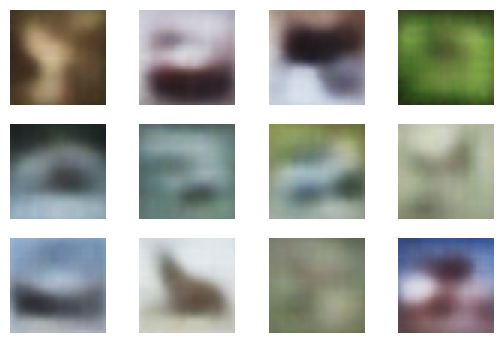

In [18]:
figure = plt.figure(figsize=(6.4, 4.2))
for i in range(12):
  figure.add_subplot(3, 4, i + 1)
  plt.imshow(reconstructions[i])
  plt.axis("off")
plt.show()